In [2]:
import zarr
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from global_land_mask import globe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import scipy
import datetime

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import Image

mpl.rcParams['figure.dpi']= 150
plt.rcParams.update({'font.size': 8})
mpl.rcParams['axes.linewidth'] = 0.3
g = 9.80616 #Avg. gravity acceleration on Earth

In [3]:
dataset = xr.open_dataset('/Users/rm65238/Documents/PIKART/PIKARTV1_lagrangian_ERA5_0p5deg_6hr_2023.nc')

In [33]:
#trackid: 1663
#time: 1428
#longitude: 720
#latitude: 360
#coordinate: 2
#max_contour_size: 1815
#max_axis_size: 671
#component: 3

In [48]:
# Select an AR and time index to plot (customize as needed)
trackid = 2
timeidx = 0  # First timestep

# Extract axis and contour data for the selected track and time
axis = dataset.variables['axis'][timeidx, trackid]
head = dataset.variables['head'][timeidx, trackid]
contour = dataset.variables['contour'][timeidx, trackid]
centroid = dataset.variables['centroid'][timeidx, trackid]
time = dataset.variables['time'][timeidx]

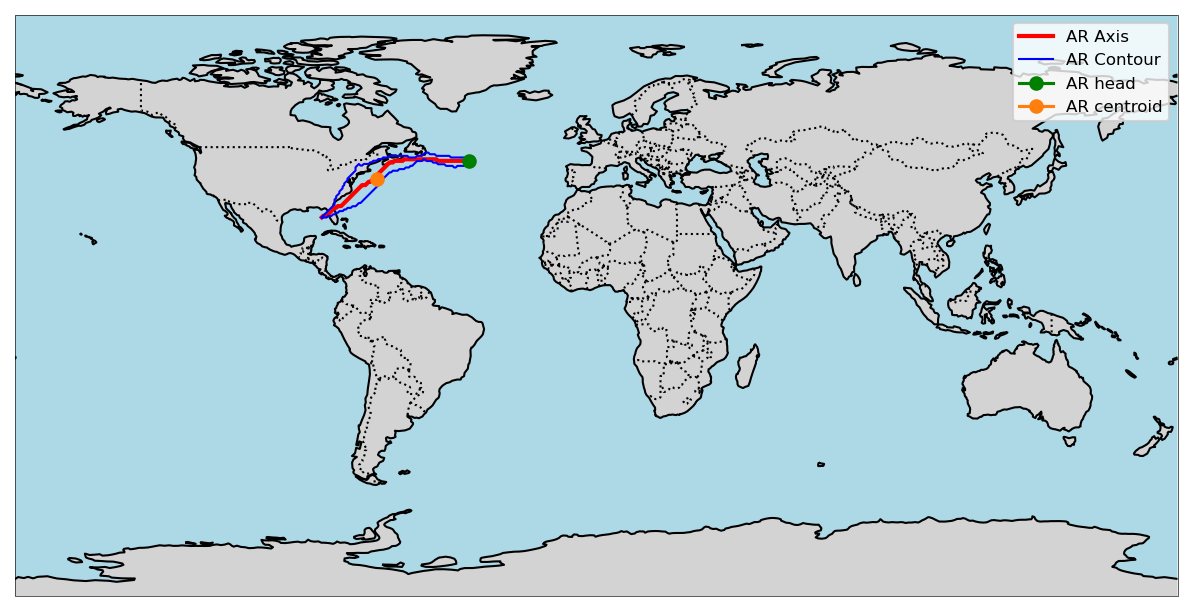

In [51]:
# Convert model time to real-world time format
base_time = datetime.datetime(1940, 1, 1, 0, 0, 0)  # Reference time for conversion
time_in_hours = float(dataset.time[timeidx])
#actual_time = base_time + datetime.timedelta(hours=time_in_hours)
#time_str = actual_time.strftime("%Y-%m-%d %H:%M UTC")  # Human-readable time string

# Plot AR axis and contour on map
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot axis (centerline of AR) and contour (outer shape of AR)
ax.plot(axis[1,:], axis[0,:], color='red', linewidth=2, label='AR Axis', transform=ccrs.PlateCarree())
ax.plot(contour[1,:], contour[0,:], color='blue', linewidth=1, label='AR Contour', transform=ccrs.PlateCarree())
ax.plot(head[1], head[0], color='green', label='AR head', marker='o', transform=ccrs.PlateCarree())
ax.plot(centroid[1], centroid[0], color='tab:orange', label='AR centroid', marker='o', transform=ccrs.PlateCarree())

# Add legend and title
ax.legend()
#ax.set_title(f"Atmospheric River\nTrack: {trackid}, Time: {time_str}")

plt.show()

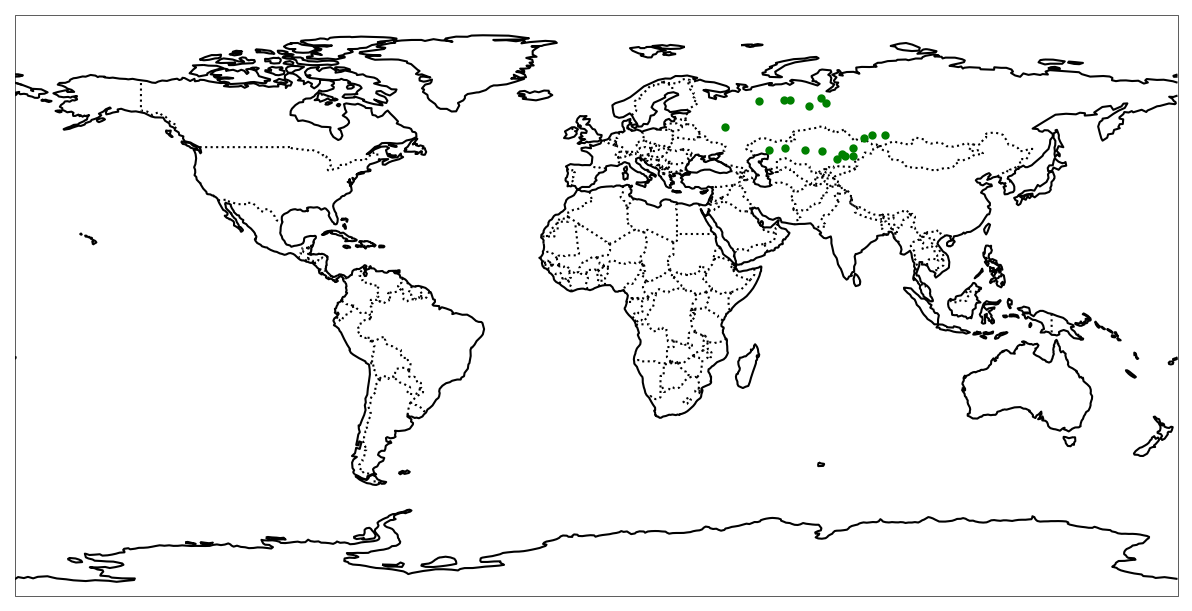

In [5]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

for j in range(0,1):
    trackid = j
    for i in range(0,20):
        timeidx = i  # First timestep
        head = dataset.variables['head'][timeidx, trackid]
        ax.plot(head[1], head[0], color='green', marker='.', transform=ccrs.PlateCarree())

plt.show()

In [11]:
from scipy.interpolate import make_interp_spline # For smoothing paths

# --- IMPORTANT: Load your full multi-timestep PIKART Lagrangian dataset here ---
# Replace 'path/to/your/pikart_lagrangian_catalog.nc' with the actual path.
# Example:
# dataset = xr.open_dataset('path/to/your/pikart_lagrangian_catalog.nc')

# --- Plotting Parameters ---
num_timesteps_to_plot = min(1428, dataset.dims['time'])
num_trackids_to_plot = min(1663, dataset.dims['trackid'])
# Factor to increase the number of points for smoothing.
# Higher value = smoother curve but potentially slower generation.
smoothing_factor = 5

# --- Figure Setup ---
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))

ax.set_global()
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

#ax.set_title(f"Paths of AR Heads (First {num_timesteps_to_plot} Timesteps)")
ax.set_title(f"Paths of AR Heads, all timesteps for 2023)")

# --- Iterate and Plot Trajectories ---
plotted_any_trajectory = False

for trackid_val in dataset['trackid'].values[:num_trackids_to_plot]:
    # Select head longitude and latitude for the current trackid and timesteps
    # Coordinates are (lat, lon), so access lon with index 1, lat with index 0
    head_lons_raw = dataset['head'].sel(trackid=trackid_val, coordinate=1).isel(time=slice(0, num_timesteps_to_plot)).values
    head_lats_raw = dataset['head'].sel(trackid=trackid_val, coordinate=0).isel(time=slice(0, num_timesteps_to_plot)).values

    # Remove NaN values (where AR head is not defined)
    valid_mask = ~np.isnan(head_lons_raw) & ~np.isnan(head_lats_raw)
    head_lons = head_lons_raw[valid_mask]
    head_lats = head_lats_raw[valid_mask]

    # Process longitudes to handle antimeridian crossings and then smooth each segment
    if head_lons.size > 1:
        segments_lons = []
        segments_lats = []
        current_segment_lons = [head_lons[0]]
        current_segment_lats = [head_lats[0]]

        for i in range(1, len(head_lons)):
            # Check for large longitude jumps (e.g., crossing the antimeridian)
            if np.abs(head_lons[i] - current_segment_lons[-1]) > 180:
                if len(current_segment_lons) > 1: # Add current segment if it has enough points
                    segments_lons.append(np.array(current_segment_lons))
                    segments_lats.append(np.array(current_segment_lats))
                current_segment_lons = [] # Start a new segment
                current_segment_lats = []
            current_segment_lons.append(head_lons[i])
            current_segment_lats.append(head_lats[i])

        if len(current_segment_lons) > 0: # Add the last segment
            segments_lons.append(np.array(current_segment_lons))
            segments_lats.append(np.array(current_segment_lats))

        # Interpolate and plot each segment
        for seg_lons, seg_lats in zip(segments_lons, segments_lats):
            if len(seg_lons) >= 4: # Need at least 4 points for k=3 (cubic) spline
                t = np.arange(len(seg_lons))
                t_new = np.linspace(t.min(), t.max(), smoothing_factor * len(seg_lons))

                spl_lon = make_interp_spline(t, seg_lons, k=3)
                spl_lat = make_interp_spline(t, seg_lats, k=3)

                smooth_lons = spl_lon(t_new)
                smooth_lats = spl_lat(t_new)

                ax.plot(smooth_lons, smooth_lats, color='black', linewidth=1, transform=ccrs.PlateCarree())
                plotted_any_trajectory = True
            elif len(seg_lons) > 1: # Plot as linear segment if not enough points for spline (e.g., 2 or 3 points)
                ax.plot(seg_lons, seg_lats, color='black', linewidth=1, transform=ccrs.PlateCarree())
                plotted_any_trajectory = True
            elif len(seg_lons) == 1: # Plot single point (no line)
                ax.plot(seg_lons, seg_lats, color='black', marker='o', markersize=2, transform=ccrs.PlateCarree())
                plotted_any_trajectory = True

# --- Display ---
if not plotted_any_trajectory:
    print(f"\nNo AR head trajectories were found or plotted for the selected trackids over the first {num_timesteps_to_plot} timesteps.")
    print("Please ensure your 'dataset' contains valid 'head' trajectory data for these ARs and time range.")

plt.tight_layout()
plt.show()

/var/folders/28/lbyg84813498_l4bwzbgsg940000gq/T/ipykernel_52177/453425552.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_timesteps_to_plot = min(1428, dataset.dims['time'])
/var/folders/28/lbyg84813498_l4bwzbgsg940000gq/T/ipykernel_52177/453425552.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_trackids_to_plot = min(1663, dataset.dims['trackid'])


/var/folders/28/lbyg84813498_l4bwzbgsg940000gq/T/ipykernel_52177/3373388588.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_timesteps_to_plot = min(1428, dataset.dims['time'])
/var/folders/28/lbyg84813498_l4bwzbgsg940000gq/T/ipykernel_52177/3373388588.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_trackids_to_plot = min(1663, dataset.dims['trackid'])


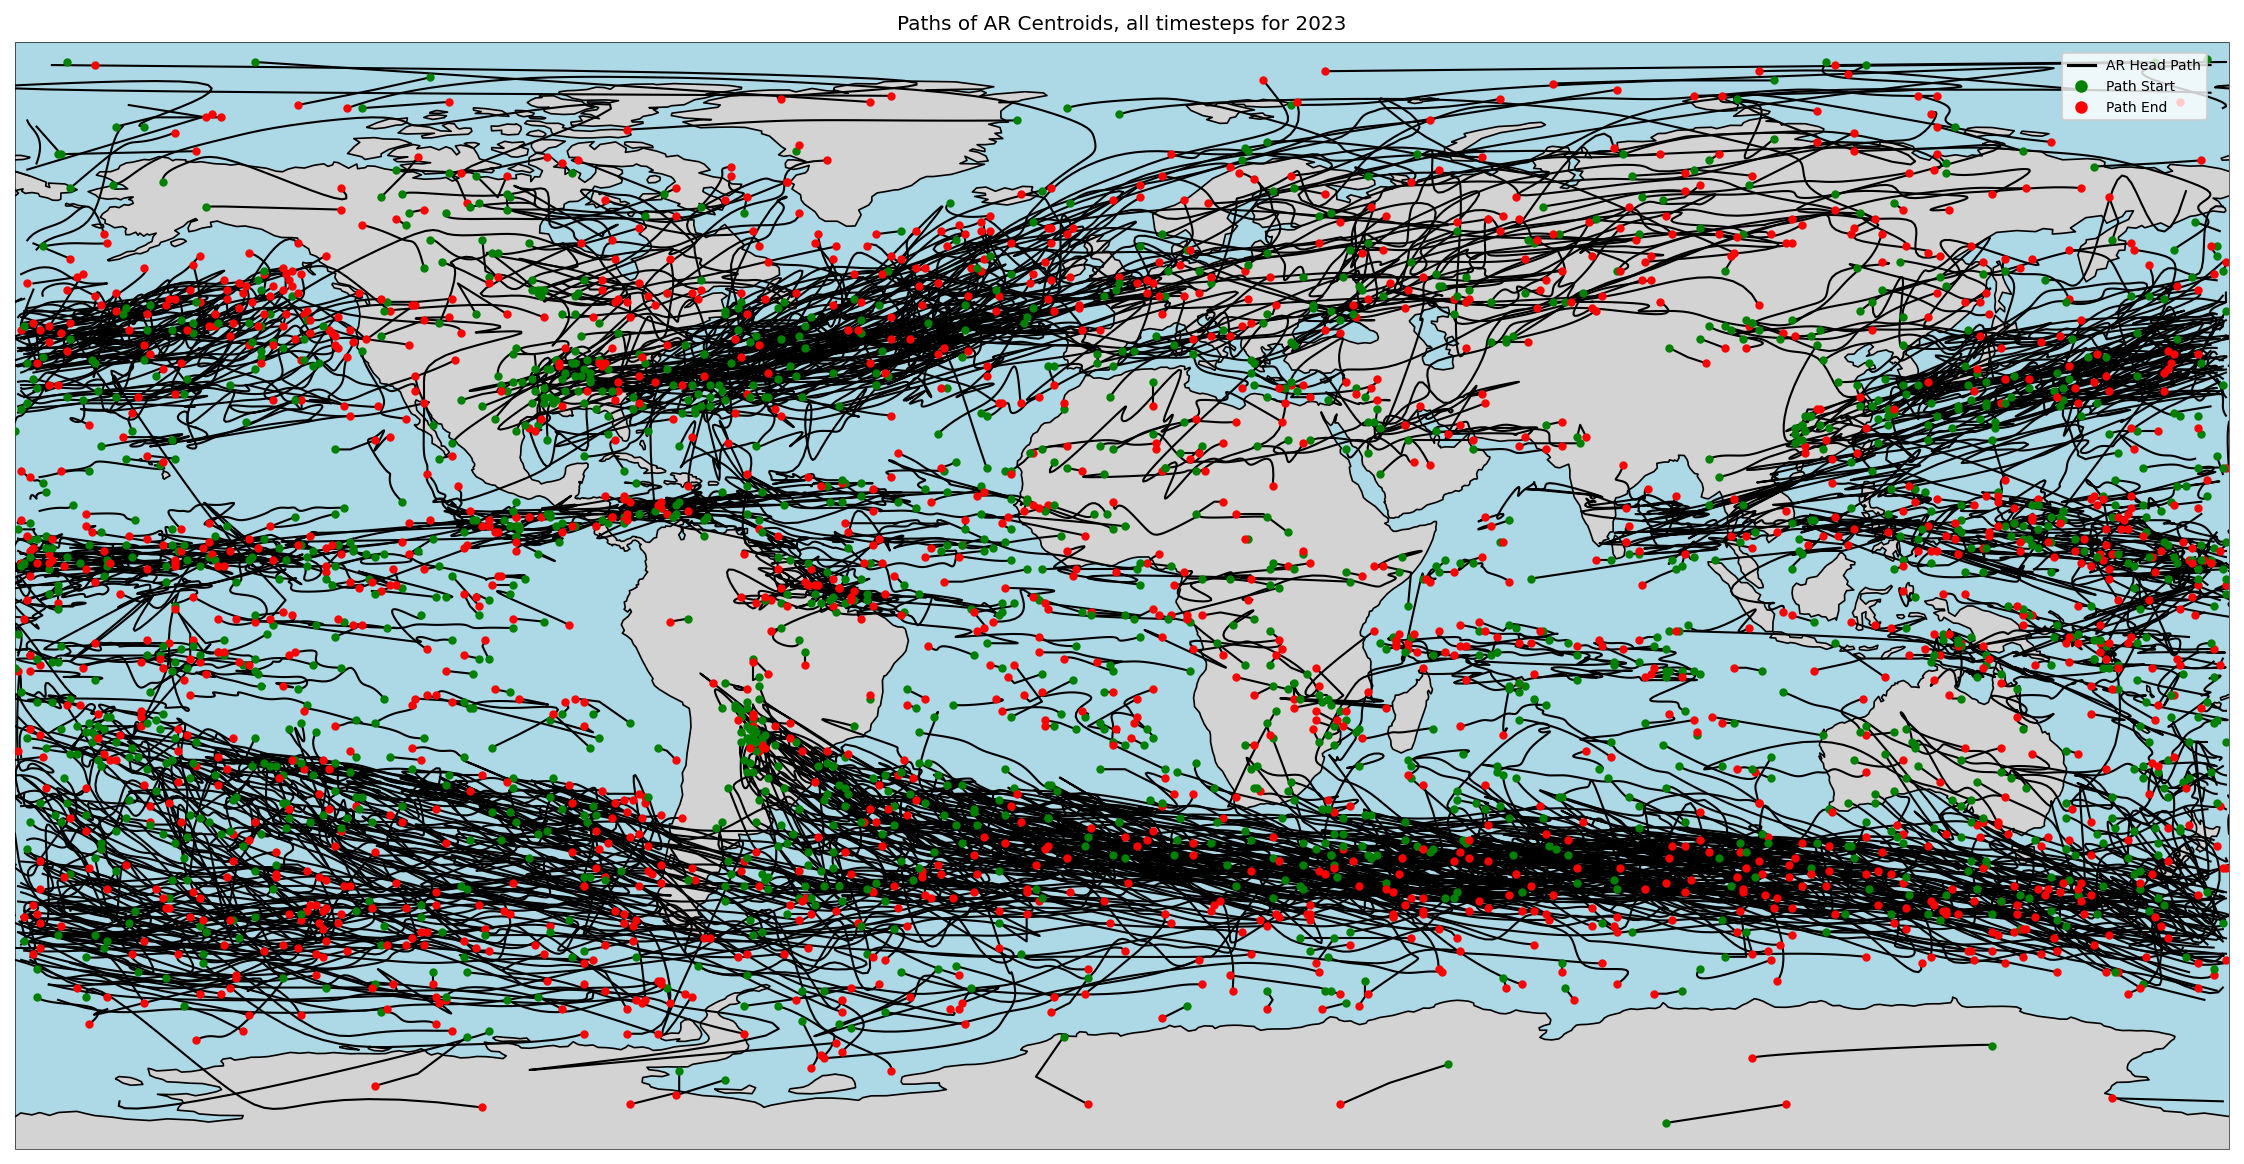

In [13]:
from scipy.interpolate import make_interp_spline # For smoothing paths
from matplotlib.lines import Line2D # For creating custom legend handles

# --- IMPORTANT: Load your full multi-timestep PIKART Lagrangian dataset here ---
# Replace 'path/to/your/pikart_lagrangian_catalog.nc' with the actual path.
# Example:
# dataset = xr.open_dataset('path/to/your/pikart_lagrangian_catalog.nc')

# --- Plotting Parameters ---
num_timesteps_to_plot = min(1428, dataset.dims['time'])
num_trackids_to_plot = min(1663, dataset.dims['trackid'])
smoothing_factor = 5 # Factor to increase points for spline interpolation

# --- Figure Setup ---
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))

ax.set_global()
ax.coastlines(linewidth=0.8)
#ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

#ax.set_title(f"Paths of AR Heads (First {num_timesteps_to_plot} Timesteps)")
ax.set_title(f"Paths of AR Centroids, all timesteps for 2023")

# Flags to add legend entries only once
start_marker_added = False
end_marker_added = False
plotted_any_trajectory = False

# --- Iterate and Plot Trajectories ---
for trackid_val in dataset['trackid'].values[:num_trackids_to_plot]:
    # Select head longitude and latitude for the current trackid and timesteps
    # Coordinates are (lat, lon), so access lon with index 1, lat with index 0
    head_lons_raw = dataset['centroid'].sel(trackid=trackid_val, coordinate=1).isel(time=slice(0, num_timesteps_to_plot)).values
    head_lats_raw = dataset['centroid'].sel(trackid=trackid_val, coordinate=0).isel(time=slice(0, num_timesteps_to_plot)).values

    # Remove NaN values (where AR head is not defined for this specific timestep)
    valid_mask = ~np.isnan(head_lons_raw) & ~np.isnan(head_lats_raw)
    head_lons = head_lons_raw[valid_mask]
    head_lats = head_lats_raw[valid_mask]
    
    # Process longitudes to handle antimeridian crossings and then smooth each segment
    if head_lons.size > 1:
        plotted_any_trajectory = True # Mark that at least one trajectory is processed

        segments_lons = []
        segments_lats = []
        current_segment_lons = [head_lons[0]]
        current_segment_lats = [head_lats[0]]

        for i in range(1, len(head_lons)):
            # Check for large longitude jumps (e.g., crossing the antimeridian)
            # This threshold (180 degrees) is a common way to detect jumps across the date line
            if np.abs(head_lons[i] - current_segment_lons[-1]) > 180:
                if len(current_segment_lons) > 1: # Add current segment if it has enough points
                    segments_lons.append(np.array(current_segment_lons))
                    segments_lats.append(np.array(current_segment_lats))
                current_segment_lons = [] # Start a new segment
                current_segment_lats = []
            current_segment_lons.append(head_lons[i])
            current_segment_lats.append(head_lats[i])

        if len(current_segment_lons) > 0: # Add the last segment
            segments_lons.append(np.array(current_segment_lons))
            segments_lats.append(np.array(current_segment_lats))

        # Interpolate and plot each segment
        for seg_lons, seg_lats in zip(segments_lons, segments_lats):
            if len(seg_lons) >= 2: # Need at least 2 points to draw a line
                if len(seg_lons) >= 4: # Need at least 4 points for k=3 (cubic) spline
                    t = np.arange(len(seg_lons))
                    t_new = np.linspace(t.min(), t.max(), smoothing_factor * len(seg_lons))

                    spl_lon = make_interp_spline(t, seg_lons, k=3)
                    spl_lat = make_interp_spline(t, seg_lats, k=3)

                    smooth_lons = spl_lon(t_new)
                    smooth_lats = spl_lat(t_new)

                    ax.plot(smooth_lons, smooth_lats, color='black', linewidth=1, transform=ccrs.PlateCarree())
                else: # Plot as linear segment if not enough points for spline (e.g., 2 or 3 points)
                    ax.plot(seg_lons, seg_lats, color='black', linewidth=1, transform=ccrs.PlateCarree())

        # Mark the beginning and end of the *entire* valid trajectory
        if head_lons.size > 0:
            # Start point (first valid coordinate)
            ax.plot(head_lons[0], head_lats[0], color='green', marker='o', markersize=3, transform=ccrs.PlateCarree(),
                    zorder=3, label='Path Start' if not start_marker_added else "")
            start_marker_added = True

            # End point (last valid coordinate)
            ax.plot(head_lons[-1], head_lats[-1], color='red', marker='o', markersize=3, transform=ccrs.PlateCarree(),
                    zorder=3, label='Path End' if not end_marker_added else "")
            end_marker_added = True

    elif head_lons.size == 1: # Plot single point if only one valid point exists for the trajectory
        plotted_any_trajectory = True
        ax.plot(head_lons[0], head_lats[0], color='green', marker='o', markersize=3, transform=ccrs.PlateCarree(),
                zorder=3, label='Path Start' if not start_marker_added else "")
        start_marker_added = True
        # If only one point, it's both start and end, but we only need to mark it once meaningfully
        ax.plot(head_lons[0], head_lats[0], color='red', marker='o', markersize=3, transform=ccrs.PlateCarree(),
                zorder=3, label='Path End' if not end_marker_added else "")
        end_marker_added = True


# --- Legend and Display ---
if not plotted_any_trajectory:
    print(f"\nNo AR head trajectories were found or plotted for the selected trackids over the first {num_timesteps_to_plot} timesteps.")
    print("Please ensure your 'dataset' contains valid 'head' trajectory data for these ARs and time range.")
else:
    # Create custom legend handles for the markers
    legend_handles = [
        Line2D([0], [0], color='black', lw=1.5, label='AR Head Path'),
        Line2D([0], [0], marker='o', color='green', markersize=5, label='Path Start', linestyle='None'),
        Line2D([0], [0], marker='o', color='red', markersize=5, label='Path End', linestyle='None')
    ]
    ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(0.99, 0.99),
              frameon=True, fontsize='small', borderaxespad=0.)

plt.tight_layout()
plt.show()